In [16]:
# Init enviroment

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [17]:
# Subscribe SPARQL query to retrieve the images and labels as desired

from SPARQLWrapper import SPARQLWrapper, JSON, POST
import json, os 
from query_util_redundancy_filter import *
import sys
query_file   = 'Demo-Query.sparql'
query_string = open(query_file,'r').read()
file_anno    = 'mmdetection/data/mixedDataset/annotations/query-output.json'
dataset = process_query(query_string)
with open(file_anno,'w') as outfile:
    json.dump(dataset,outfile)
    
categories = [category['name'] for category in dataset['categories']]

number_of_categories = len(categories)

In [18]:
# Define utils functions

import numpy as np
import funcy
from sklearn.model_selection import train_test_split
import Ipynb_importer
from check_annotation import print_instances_class_histogram

def save_coco(file, images, annotations, categories):
    print_instances_class_histogram(file, annotations, [category['name'] for category in categories])
    with open(file, 'wt') as coco:
        json.dump({'images': images, 'annotations': annotations, 'categories': categories}, coco, indent=2,
                  sort_keys=False)
        
def filter_annotations(annotations, images):
    image_ids = funcy.lmap(lambda i: int(i['id']), images)
    return funcy.lfilter(lambda a: int(a['image_id']) in image_ids, annotations)

def dataset_split(annotation_file, path_to_train, path_to_test, ratio):
    with open(annotation_file, 'rt') as annotations:
        coco = json.load(annotations)
        images = coco['images']
        annotations = coco['annotations']
        categories = coco['categories']

        images_with_annotations = funcy.lmap(lambda a: int(a['image_id']), annotations)
        images = funcy.lremove(lambda i: i['id'] not in images_with_annotations, images)

        train, test = train_test_split(images, train_size=ratio)

        save_coco(path_to_train, train, filter_annotations(annotations, train), categories)
        save_coco(path_to_test, test, filter_annotations(annotations, test), categories)

In [20]:
# Split data into train, val, test sets

import json
path_to_train_val = 'mmdetection/data/mixedDataset/annotations/train-val-set.json'
path_to_train = 'mmdetection/data/mixedDataset/annotations/train-set.json'
path_to_val = 'mmdetection/data/mixedDataset/annotations/val-set.json'
path_to_test = 'mmdetection/data/mixedDataset/annotations/test-set.json'
ratio = 0.85

dataset_split(file_anno, path_to_train_val, path_to_test, ratio)
dataset_split(path_to_train_val, path_to_train, path_to_val, ratio)

with open(path_to_val) as json_object:
    categories_dict =json.load(json_object)
categories= [category['name'] for category in categories_dict['categories']]
number_of_categories=len(categories)

2021-07-12 03:16:28 b50e93830b86 root[337012] INFO 
Categories and Instances in the mmdetection/data/mixedDataset/annotations/train-val-set.json:
|   category   | #instances   |   category   | #instances   |   category   | #instances   |
|:------------:|:-------------|:------------:|:-------------|:------------:|:-------------|
|     cat      | 17           |     dog      | 1            |  motorcycle  | 5            |
|    person    | 37           |     car      | 1            |    couch     | 0            |
|    bottle    | 2            | potted plant | 1            | refrigerator | 1            |
|    clock     | 3            |    orange    | 7            |     oven     | 1            |
|     sink     | 2            |   handbag    | 1            |    spoon     | 1            |
|     bowl     | 3            |     book     | 0            |    chair     | 12           |
| dining table | 7            |     bed      | 1            |   bicycle    | 3            |
|  cell phone  | 2        

In [21]:
# Perform training the dataset using a particular objects detection tool

%run mmdetection/tools/train.py \
mmdetection/configs/fcos/fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py \
--work-dir mmdetection/training_logs_example/fcos_coco_kitti_pedestrian_person_setting_bacth_4_lr_0.01/ \
--cfg-options model.bbox_head.num_classes={number_of_categories} \
data.train.ann_file={path_to_train} \
data.val.ann_file={path_to_val} \
runner.max_epochs=30 \
data.samples_per_gpu=4 \
load_from=mmdetection/pths/fcos/fcos_r50_caffe_fpn_gn-head_1x_coco.pth \
data.train.classes="$categories" \
data.val.classes="$categories" \
data.test.classes="$categories"

2021-07-12 03:16:53,331 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.10 (default, Jun  4 2021, 14:48:32) [GCC 7.5.0]
CUDA available: True
GPU 0: Tesla V100-PCIE-16GB
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GCC: gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
PyTorch: 1.8.1
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-ge

2021-07-12 03:16:56 b50e93830b86 mmdet[337012] INFO Config:
dataset_type = 'MixedDataset'
data_root = 'data/mixedDataset/'
img_norm_cfg = dict(
    mean=[102.9801, 115.9465, 122.7717], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromSeparatedFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[102.9801, 115.9465, 122.7717],
        std=[1.0, 1.0, 1.0],
        to_rgb=False),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromSeparatedFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            d

2021-07-12 03:16:56 b50e93830b86 mmcv[337012] WARNING The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias, layer1.0.conv1.bias, layer1.0.conv2.bias, layer1.0.conv3.bias, layer1.0.downsample.0.bias, layer1.1.conv1.bias, layer1.1.conv2.bias, layer1.1.conv3.bias, layer1.2.conv1.bias, layer1.2.conv2.bias, layer1.2.conv3.bias, layer2.0.conv1.bias, layer2.0.conv2.bias, layer2.0.conv3.bias, layer2.0.downsample.0.bias, layer2.1.conv1.bias, layer2.1.conv2.bias, layer2.1.conv3.bias, layer2.2.conv1.bias, layer2.2.conv2.bias, layer2.2.conv3.bias, layer2.3.conv1.bias, layer2.3.conv2.bias, layer2.3.conv3.bias, layer3.0.conv1.bias, layer3.0.conv2.bias, layer3.0.conv3.bias, layer3.0.downsample.0.bias, layer3.1.conv1.bias, layer3.1.conv2.bias, layer3.1.conv3.bias, layer3.2.conv1.bias, layer3.2.conv2.bias, layer3.2.conv3.bias, layer3.3.conv1.bias, layer3.3.conv2.bias, layer3.3.conv3.bias, layer3.4.conv1.bias, layer3.4.conv2.bias, layer3.4.conv3.bias, lay

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2021-07-12 03:16:57,271 - mmdet - INFO - load checkpoint from mmdetection/pths/fcos/fcos_r50_caffe_fpn_gn-head_1x_coco.pth
2021-07-12 03:16:57 b50e93830b86 mmdet[337012] INFO load checkpoint from mmdetection/pths/fcos/fcos_r50_caffe_fpn_gn-head_1x_coco.pth
2021-07-12 03:16:57,275 - mmdet - INFO - Use load_from_local loader
2021-07-12 03:16:57 b50e93830b86 mmdet[337012] INFO Use load_from_local loader
2021-07-12 03:16:57,457 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.conv_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([25, 256, 3, 3]).
size mismatch for bbox_head.conv_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([25]).
2021-07-12 03:16:57 b50e93830b86 mmdet[337012] WARNING The model and loaded state dict do not match exactly

size mismatch for bbox_head.conv_cls.weight: copying a param 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2021-07-12 03:17:01,848 - mmdet - INFO - Saving checkpoint at 1 epochs
2021-07-12 03:17:01 b50e93830b86 mmdet[337012] INFO Saving checkpoint at 1 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2021-07-12 03:17:03,812 - mmdet - INFO - Evaluating bbox...
2021-07-12 03:17:03 b50e93830b86 mmdet[337012] INFO Evaluating bbox...
2021-07-12 03:17:03,816 - mmdet - ERROR - The testing results of the whole dataset is empty.
2021-07-12 03:17:03 b50e93830b86 mmdet[337012] ERROR The testing results of the whole dataset is empty.
2021-07-12 03:17:03,820 - mmdet - INFO - Exp name: fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py
2021-07-12 03:17:03 b50e93830b86 mmdet[337012] INFO Exp name: fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py
2021-07-12 03:17:03,822 - mmdet - INFO - Epoch(val) [1][3]	
2021-07-12 03:17:03 b50e93830b86 mmdet[337012] INFO Epoch(val) [1][3]	


Loading and preparing results...


2021-07-12 03:17:06,996 - mmdet - INFO - Exp name: fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py
2021-07-12 03:17:06 b50e93830b86 mmdet[337012] INFO Exp name: fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py
2021-07-12 03:17:07,000 - mmdet - INFO - Epoch(val) [1][2]	loss_cls: 1.0643, loss_bbox: 0.2355, loss_centerness: 0.5717, loss: 1.8714
2021-07-12 03:17:07 b50e93830b86 mmdet[337012] INFO Epoch(val) [1][2]	loss_cls: 1.0643, loss_bbox: 0.2355, loss_centerness: 0.5717, loss: 1.8714
2021-07-12 03:17:11,390 - mmdet - INFO - Saving checkpoint at 2 epochs
2021-07-12 03:17:11 b50e93830b86 mmdet[337012] INFO Saving checkpoint at 2 epochs


RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 184884800 vs 184884688

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Use load_from_local loader
[                                                  ] 0/3, elapsed: 0s, ETA:

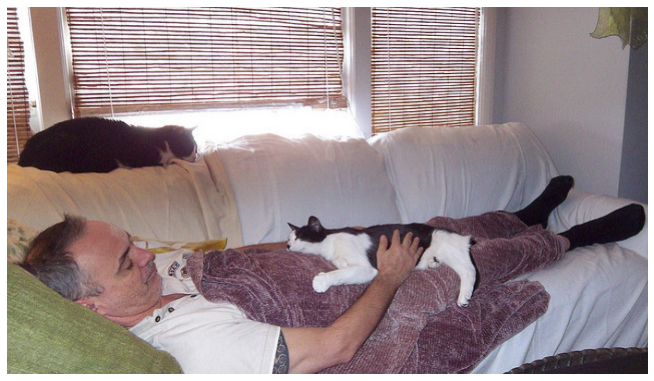

[>>>>>>>>>>>>>>>>                                  ] 1/3, 1.2 task/s, elapsed: 1s, ETA:     2s

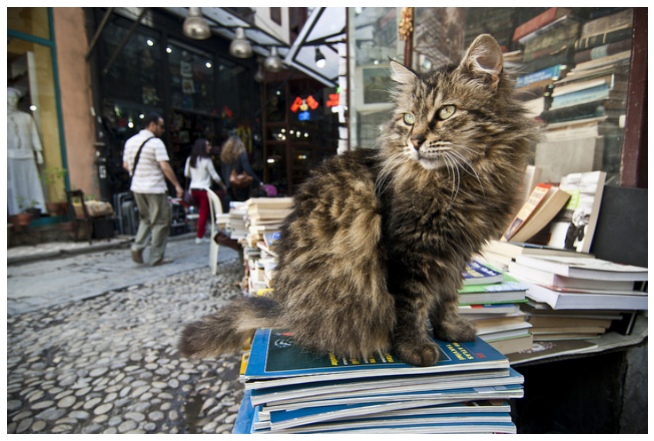

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>                 ] 2/3, 1.5 task/s, elapsed: 1s, ETA:     1s

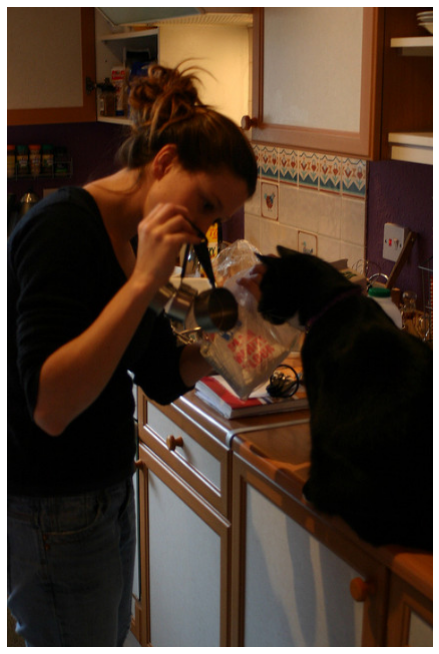

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 1.7 task/s, elapsed: 2s, ETA:     0s
writing results to mmdetection/training_logs_example/fcos_coco_kitti_pedestrian_person_setting_bacth_4_lr_0.01/result_test_person.pkl

Evaluating bbox...
Loading and preparing results...
The testing results of the whole dataset is empty.
OrderedDict()


In [22]:
%run mmdetection/tools/test.py \
mmdetection/configs/fcos/fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py \
mmdetection/training_logs_example/fcos_coco_kitti_pedestrian_person_setting_bacth_4_lr_0.01/latest.pth \
--work-dir mmdetection/training_logs_example/fcos_coco_kitti_pedestrian_person_setting_bacth_4_lr_0.01/ \
--out mmdetection/training_logs_example/fcos_coco_kitti_pedestrian_person_setting_bacth_4_lr_0.01/result_test_person.pkl \
--cfg-options data.test.ann_file={path_to_test} \
model.bbox_head.num_classes={number_of_categories} \
data.samples_per_gpu=4 \
data.train.classes="$categories" \
data.val.classes="$categories" \
data.test.classes="$categories" \
--eval bbox \
--show